In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [2]:
# Loading the Excel dataset
data = pd.read_excel("Real estate valuation data set.xlsx")

In [3]:
# 1. Exploratory Data Analysis (EDA):

# Checking for missing values
missing_values = data.isnull().sum()

# Examining the distribution of the target variable
target_distribution = data["Y house price of unit area"].describe()

# Identifying potential outliers using the IQR method
Q1 = data["Y house price of unit area"].quantile(0.25)
Q3 = data["Y house price of unit area"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = data[(data["Y house price of unit area"] < lower_bound) | (data["Y house price of unit area"] > upper_bound)]

missing_values, target_distribution, outliers.shape[0]

(X1 transaction date                       0
 X2 house age                              0
 X3 distance to the nearest MRT station    0
 X4 number of convenience stores           0
 X5 latitude                               0
 X6 longitude                              0
 Y house price of unit area                0
 dtype: int64,
 count    414.000000
 mean      37.980193
 std       13.606488
 min        7.600000
 25%       27.700000
 50%       38.450000
 75%       46.600000
 max      117.500000
 Name: Y house price of unit area, dtype: float64,
 3)

/Users/guardian/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


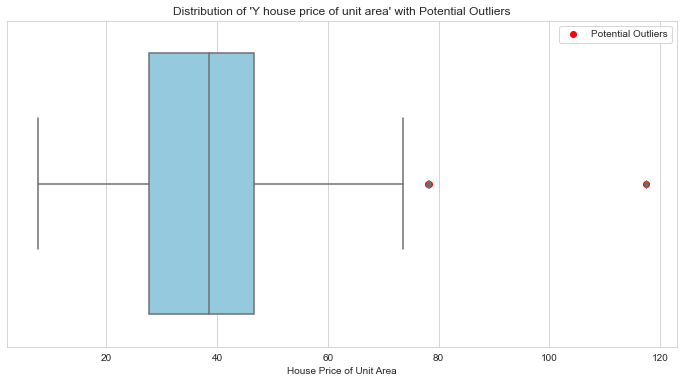

In [4]:
# Setting up the plot style
sns.set_style("whitegrid")

# Plotting the distribution of the target variable and potential outliers again
plt.figure(figsize=(12, 6))
sns.boxplot(data["Y house price of unit area"], color='skyblue')
plt.scatter(outliers["Y house price of unit area"], [0]*outliers.shape[0], color='red', marker='o', label='Potential Outliers')
plt.title("Distribution of 'Y house price of unit area' with Potential Outliers")
plt.xlabel("House Price of Unit Area")
plt.legend()
plt.show()

I'm going to be keeping these outliers since they may contain factual information.

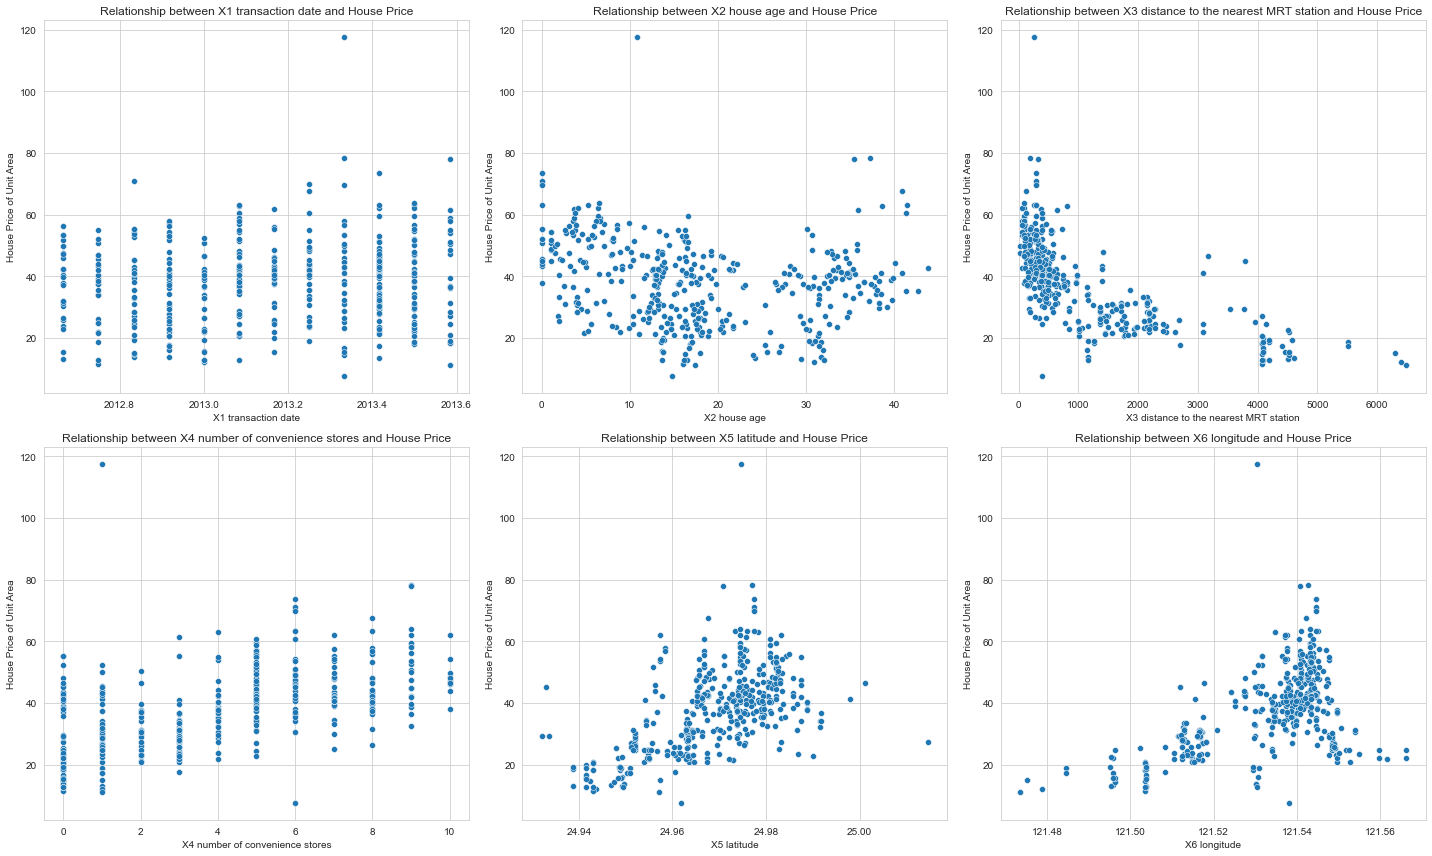

In [5]:
# Visualizing relationships between features and the target variable

# Setting up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

# List of features to visualize
features = ['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 
            'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']

for i, feature in enumerate(features):
    sns.scatterplot(x=data[feature], y=data['Y house price of unit area'], ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f"Relationship between {feature} and House Price")
    axes[i//3, i%3].set_ylabel("House Price of Unit Area")

plt.tight_layout()
plt.show()

1. **X1 transaction date**: There doesn't seem to be a strong linear relationship between the transaction date and house price.
2. **X2 house age**: Older houses tend to have a slightly lower price, although there's a lot of variance.
3. **X3 distance to the nearest MRT station**: There's a noticeable trend where houses closer to MRT stations (lower distance values) tend to have higher prices.
4. **X4 number of convenience stores**: Houses with more nearby convenience stores generally have higher prices.
5. **X5 latitude & X6 longitude**: These plots show some clustering, indicating specific geographic areas where house prices might be higher or lower.

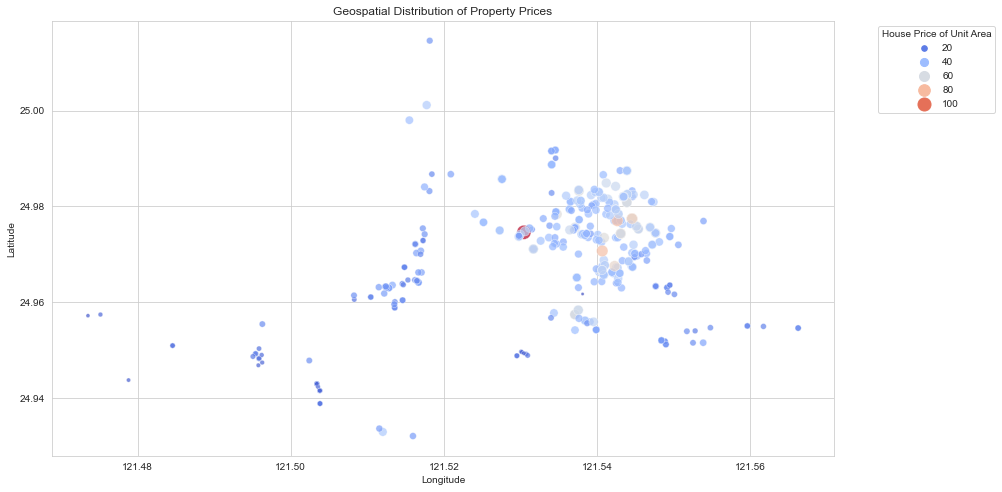

In [6]:
# Visualizing geospatial data using latitude and longitude without the colorbar

plt.figure(figsize=(14, 8))
plot = sns.scatterplot(x=data["X6 longitude"], y=data["X5 latitude"], hue=data["Y house price of unit area"], 
                palette="coolwarm", size=data["Y house price of unit area"], sizes=(10, 200), alpha=0.7)

plt.title("Geospatial Distribution of Property Prices")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plot.legend(title="House Price of Unit Area", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Specific regions have properties with higher prices, likely indicating more upscale or desirable neighborhoods.
There are clusters of properties, suggesting similar pricing patterns within those areas.

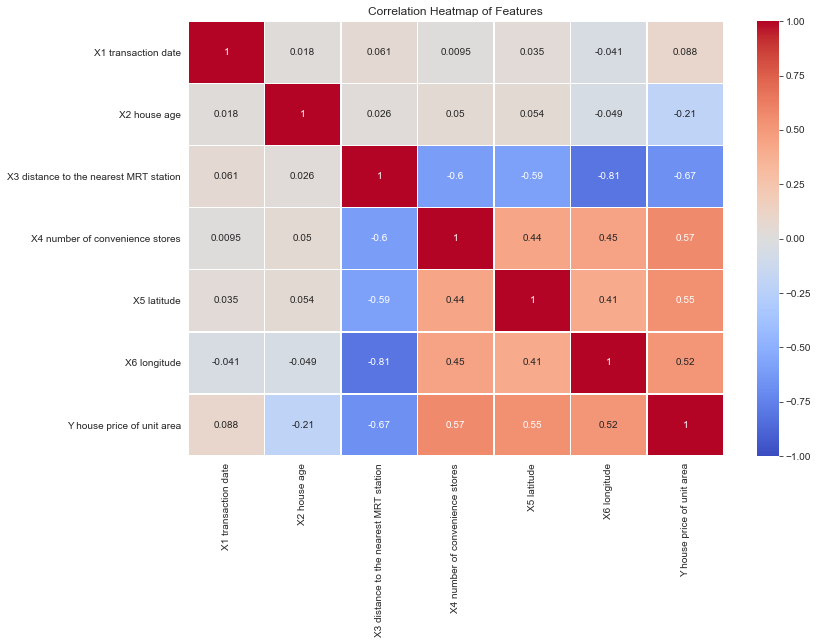

In [7]:
# Calculating the correlation matrix
correlation_matrix = data.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Features")
plt.show()

From the heatmap, we can observe:
1. The distance to the nearest MRT station (`X3`) has a significant negative correlation with the house price (`Y`). This aligns with the earlier observation that properties closer to MRT stations tend to have higher prices.
2. The number of convenience stores (`X4`) has a positive correlation with the house price.
3. Latitude (`X5`) and Longitude (`X6`) also show some correlation with the house price, indicating location-specific pricing patterns.

In [8]:
# Convert the transaction date:
# Extracting year and month from the transaction date
data['transaction_year'] = data['X1 transaction date'].astype(int)
data['transaction_month'] = ((data['X1 transaction date'] - data['transaction_year']) * 12).astype(int) + 1

# Dropping the original transaction date column
data.drop('X1 transaction date', axis=1, inplace=True)

# Normalize or standardize the features:
# Since most regression algorithms perform better with standardized features, we'll standardize them.
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [9]:
# Checking for categorical data in the dataset by examining unique values in each column
unique_values = scaled_data.nunique()

# Identifying columns that have a relatively low number of unique values, which might suggest they are categorical
potential_categorical_columns = unique_values[unique_values < 15].index.tolist()

# Displaying examples from the potential categorical columns
examples_from_categorical_columns = data[potential_categorical_columns].sample(10)

examples_from_categorical_columns

,X4 number of convenience stores,transaction_year,transaction_month
296,4,2012,10
181,8,2013,3
94,5,2012,12
156,0,2013,7
371,5,2013,7
209,8,2012,10
300,4,2013,1
128,6,2013,1
103,6,2012,10
85,9,2012,10


Given the nature of the "X4 number of convenience stores" column and its inherent ordinal relationship (where the order matters), I'm going to keep it discrete. The same goes for transaction_year and transaction_month.

In [10]:
# Separating the features and target variable
X = scaled_data.drop("Y house price of unit area", axis=1)
y = scaled_data["Y house price of unit area"]

# Splitting the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Initializing the models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Trees": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGB": xgb.XGBRegressor(random_state=42)
}

# Training the models and evaluating on the test set
results = {}
for name, model in models.items():
    # Training the model
    model.fit(X_train, y_train)
    
    # Predicting on the test set
    y_pred = model.predict(X_test)
    
    # Storing evaluation metrics
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R-squared": r2_score(y_test, y_pred)
    }

# Creating a DataFrame for the evaluation metrics
results_df = pd.DataFrame(results).T

results_df

,MAE,MSE,R-squared
Linear Regression,0.389836,0.291153,0.679465
Decision Trees,0.388218,0.311116,0.657487
Random Forest,0.291424,0.170937,0.811813
Gradient Boosting,0.279133,0.170365,0.812443
XGB,0.312399,0.197217,0.782881


In [12]:
# Hyperparameters grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Hyperparameters grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search for Random Forest
rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, 
                              cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train, y_train)

# Grid search for Gradient Boosting
gb_grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_param_grid, 
                              cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
gb_grid_search.fit(X_train, y_train)

# Extracting best hyperparameters for each model
best_rf_params = rf_grid_search.best_params_
best_gb_params = gb_grid_search.best_params_

best_rf_params, best_gb_params

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits


({'max_depth': None,
  'min_samples_leaf': 2,
  'min_samples_split': 5,
  'n_estimators': 100},
 {'learning_rate': 0.05,
  'max_depth': 3,
  'min_samples_leaf': 1,
  'min_samples_split': 4,
  'n_estimators': 100,
  'subsample': 1.0})

In [13]:
# Best hyperparameters
best_rf_params = {
    'max_depth': None,
    'min_samples_leaf': 2,
    'min_samples_split': 5,
    'n_estimators': 100
}

best_gb_params = {
    'learning_rate': 0.05,
    'max_depth': 3,
    'min_samples_leaf': 1,
    'min_samples_split': 4,
    'n_estimators': 100,
    'subsample': 1.0
}

# Train and evaluate New Random Forest with best hyperparameters
rf_model = RandomForestRegressor(**best_rf_params, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

# Train and evaluate New Gradient Boosting with best hyperparameters
gb_model = GradientBoostingRegressor(**best_gb_params, random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)

gb_mae = mean_absolute_error(y_test, gb_predictions)
gb_mse = mean_squared_error(y_test, gb_predictions)
gb_r2 = r2_score(y_test, gb_predictions)

# Add the results to results dataframe
results_df.loc["New Random Forest"] = [rf_mae,rf_mse,rf_r2]
results_df.loc["New Gradient Boosting"] = [gb_mae,gb_mse,gb_r2]
results_df
print(f"New Random Forest - MAE: {rf_mae}, MSE: {rf_mse}, R2: {rf_r2}")
print(f"New Gradient Boosting - MAE: {gb_mae}, MSE: {gb_mse}, R2: {gb_r2}")

New Random Forest - MAE: 0.27780381185853686, MSE: 0.16566451389496933, R2: 0.8176173542194676
New Gradient Boosting - MAE: 0.27507968925732956, MSE: 0.1637508363623799, R2: 0.8197241516461373


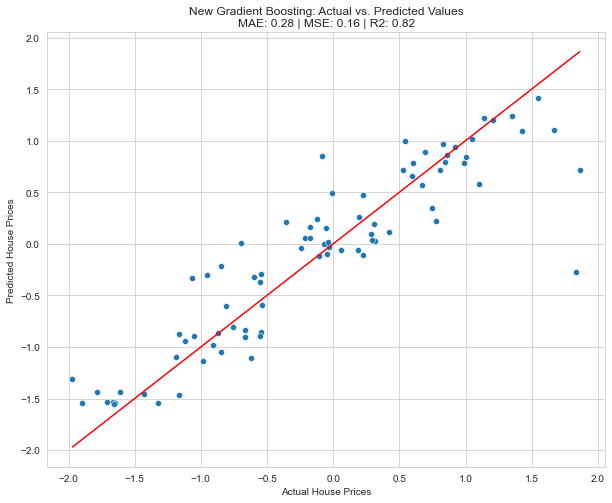

In [14]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=gb_predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # 45-degree line
plt.xlabel("Actual House Prices")
plt.ylabel("Predicted House Prices")
plt.title(f"New Gradient Boosting: Actual vs. Predicted Values\nMAE: {gb_mae:.2f} | MSE: {gb_mse:.2f} | R2: {gb_r2:.2f}")
plt.show()

- The x-axis represents the actual house prices.
- The y-axis represents the predicted house prices.
- The red line represents where the points would lie if the predicted value was equal to the actual value.

It can be seen from the plot that the model behaves somehow good but can be drastically improved.

The evaluation metrics, mainly `MAE` is based on the standardized data, so the values for MAE don't directly correspond to the original data's units. To interpret these metrics in the context of the original data, I'll need to "un-standardize" them.

I've used the `StandardScaler` from scikit-learn, the process to standardize a feature is:

standardized value = (original value - mean) / standard deviation

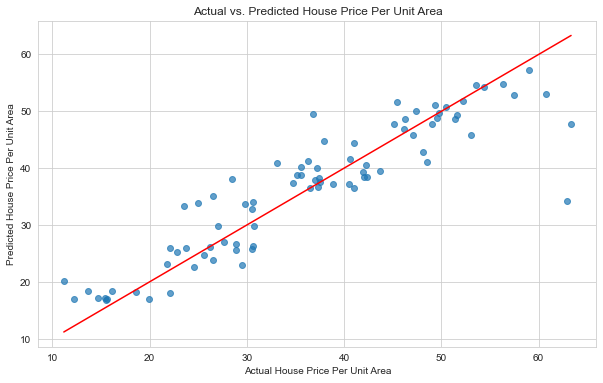

In [15]:
# Calculating the standard deviation of the target variable (before standardization)
target_std_dev = data['Y house price of unit area'].std()

# Un-standardizing the predictions
y_pred_original = (gb_predictions * target_std_dev) + data['Y house price of unit area'].mean()

# Un-standardizing the actual y_test values
y_test_original = (y_test * target_std_dev) + data['Y house price of unit area'].mean()

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.7)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red') # diagonal line
plt.xlabel('Actual House Price Per Unit Area')
plt.ylabel('Predicted House Price Per Unit Area')
plt.title('Actual vs. Predicted House Price Per Unit Area')
plt.grid(True)
plt.show()

This is the same plot of "un-standardized" predictions vs test

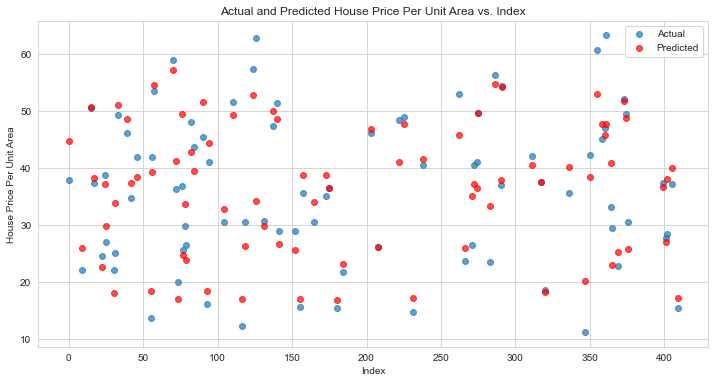

In [16]:
# Plotting the actual house price per unit area against its index
plt.figure(figsize=(12, 6))
plt.scatter(y_test_original.index, y_test_original, alpha=0.7, label="Actual")
plt.scatter(y_test_original.index, y_pred_original, alpha=0.7, color="red", label="Predicted")
plt.xlabel('Index')
plt.ylabel('House Price Per Unit Area')
plt.title('Actual and Predicted House Price Per Unit Area vs. Index')
plt.legend()
plt.grid(True)
plt.show()

This is another plot showing how the predicted values scatter along and cover the actual values

In [17]:
# Un-standardizing the MAE for "New Gradient Boosting"
original_mae_new_gb = 0.275080 * target_std_dev
original_mae_new_gb

3.74287263589303

I'm going to be calculating the relative MAE to present a basis for predictive performance evaluaiton

In [18]:
# Calculating the range of the target variable (before standardization)
target_range = data['Y house price of unit area'].max() - data['Y house price of unit area'].min()

# Calculating Relative MAE
relative_mae = original_mae_new_gb / target_range

# Calculating Relative MAE using standard deviation
relative_mae_std = original_mae_new_gb / target_std_dev

relative_mae, relative_mae_std

(0.03405707584980009, 0.27508)

Given that the unit of measurement for the house price per unit area is "10000 New Taiwan Dollar/Ping" (where 1 Ping = 3.3 square meters), this translates to a typical prediction error of approximately 37,400 New Taiwan Dollars per Ping.In relative terms, this prediction error represents about \(3.41\%\) of the range of the house price per unit area in the dataset. Alternatively, when compared to the standard deviation of house prices in the dataset, this error is about \(27.51\%\) of the typical variability in prices. These relative metrics provide context on the model's accuracy by comparing the average error to the overall spread and variability of house prices in the dataset.

For instance, if the actual price of a house per unit area was 500,000 New Taiwan Dollars per Ping, the model might predict a price anywhere between 462,600 and 537,400 New Taiwan Dollars per Ping.

The R-squared for the "New Gradient Boosting" model is 0.8197. This value represents the proportion of the variance in the dependent variable (house price per unit area) that is predictable from the independent variables (features). In this case, approximately 81.97% of the variability in house prices can be explained by the features in the model, which indicates a relatively strong predictive capability.